## Processing Sensor Data from Catalina Jemez CZO Green Pit 1
- Marc Berghouse 9/19/2020: Original format
- Zach Perzan 9/23/2020: Improved format and working PRISM concat


This array includes:
- apogee_SO110
- Vaisala_GMM220
- DecagonMPS2
- Decagon5TE

Issues:
- I'm not sure which water potential values are unrealistic

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

def plot_cols(column_list, ylabel=''):
    """Plot columns from df. Columns to plot must be in
    column_list."""
    
    n = len(column_list)

    fig, ax = plt.subplots(n, figsize=(10,3*n), tight_layout=True, sharex=True)

    for i, col in enumerate(column_list):
        ax[i].plot(df.index, df[col], label=col)
        ax[i].legend(loc='upper right')
        ax[i].set(ylabel=ylabel)
        
    return fig, ax

In [2]:
# Import each file individually as a dataframe and append it to a list of dataframes

infiles = ["../../raw_data/Catalina-Jemez/Green_Pit1/Green_pit1_co2o2_2015.csv", 
           "../../raw_data/Catalina-Jemez/Green_Pit1/Green_pit1_co2o2_2016.csv", 
           "../../raw_data/Catalina-Jemez/Green_Pit1/Green_pit1_co2o2_2017.csv", 
           "../../raw_data/Catalina-Jemez/Green_Pit1/Green_pit1_co2o2_2018.csv", 
           "../../raw_data/Catalina-Jemez/Green_Pit1/Green_pit1_soilMTP_2015.csv", 
           "../../raw_data/Catalina-Jemez/Green_Pit1/Green_pit1_soilMTP_2016.csv", 
           "../../raw_data/Catalina-Jemez/Green_Pit1/Green_pit1_soilMTP_2017.csv", 
           "../../raw_data/Catalina-Jemez/Green_Pit1/Green_pit1_soilMTP_2018.csv"]


# Lists of all dataframes
df_list = []

for infile in tqdm(infiles):
    df = pd.read_csv(infile, na_values=['NAN', -9999],  parse_dates=[0], 
                     index_col=0, skiprows=[1]) # skips the 1th row (0-indexed)
    df_list.append(df)
    
prism_path = "../../raw_data/Catalina-Jemez/Catalina-Jemez_Green_PRISM.csv"
ppt = pd.read_csv(prism_path, na_values=['NAN',-9999,-99999], skiprows=11, 
                  parse_dates=[0], index_col=0, names=['PRISM_precip.mm']) 
ppt['PRISM_precip.mm'] = pd.to_numeric(ppt['PRISM_precip.mm'])

In [3]:
columns=['ApogeeTemp_2cm.deg.C', 'ApogeeTemp_10cm.deg.C', 'ApogeeTemp_30cm.deg.C',
         'ApogeeTemp_60cm.deg.C', 'O2_2cm.percent.0-100','O2_10cm.percent.0-100',
         'O2_30cm.percent.0-100', 'O2_60cm.percent.0-100', 'CO2_2cm.ppm', 'CO2_10cm.ppm', 
         'CO2_30cm.ppm', 'CO2_60cm.ppm', 'WaterPotential_10cm.kPa','WaterPotential_30cm.kPa',
         'DecagonMPS6Temp_10cm.deg.C','DecagonMPS6Temp_30cm.deg.C', 'SoilMoistureA_10cm.m3m3',
         'SoilMoistureA_30cm.m3m3', 'SoilMoistureA_60cm.m3m3', 'SoilMoistureA_135cm.m3m3', 'BulkECA_10cm.dS/m', 
         'BulkECA_30cm.dS/m', 'BulkECA_60cm.dS/m', 'BulkECA_135cm.dS/m', 'Decagon5TETempA_10cm.deg.C',
         'Decagon5TETempA_30cm.deg.C', 'Decagon5TETempA_60cm.deg.C', 'Decagon5TETempA_135cm.deg.C',
         'SoilMoistureB_10cm.m3m3', 'SoilMoistureB_30cm.m3m3', 'SoilMoistureB_60cm.m3m3', 
         'SoilMoistureB_135cm.m3m3', 'BulkECB_10cm.dS/m', 'BulkECB_30cm.dS/m', 'BulkECB_60cm.dS/m',
         'BulkECB_135cm.dS/m', 'Decagon5TETempB_10cm.deg.C', 'Decagon5TETempB_30cm.deg.C', 
         'Decagon5TETempB_60cm.deg.C', 'Decagon5TETempB_135cm.deg.C']


# Concatenate all individual files to a single dataframe
df = pd.concat(df_list)
df.columns = columns

# Resample everything to hourly averages since certain 
# sensors are measured on different schedules
df.sort_index(inplace=True) # Sort first
df = df.resample('1H').mean()
df
# Add on up-sampled PRISM data
# (resample daily to hourly, using the nearest value, then
#  add on as new column to df)

ppt = ppt.drop((pd.date_range('2015-01-01', '2015-10-23')), errors='ignore')
hourly_ppt = ppt.resample('1H').nearest()


df.loc[hourly_ppt.index, 'PRISM_precip.mm'] = hourly_ppt['PRISM_precip.mm']

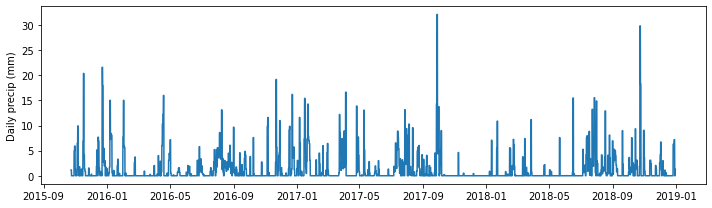

In [4]:
# Plot precip data
fig, ax = plt.subplots(figsize=(10,3), tight_layout=True)

ax.plot(df.index, df['PRISM_precip.mm'])
ax.set(ylabel='Daily precip (mm)');

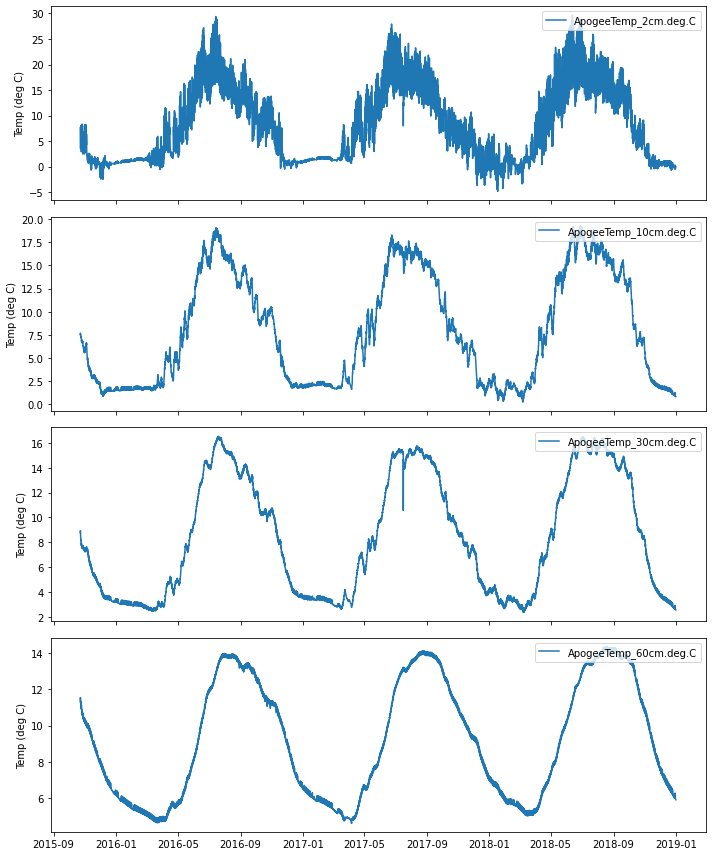

In [5]:
# Plot apogee thermistor temperature
apogee_temp_cols = [col for col in df.columns if 'ApogeeTemp' in col]
plot_cols(apogee_temp_cols, ylabel='Temp (deg C)');

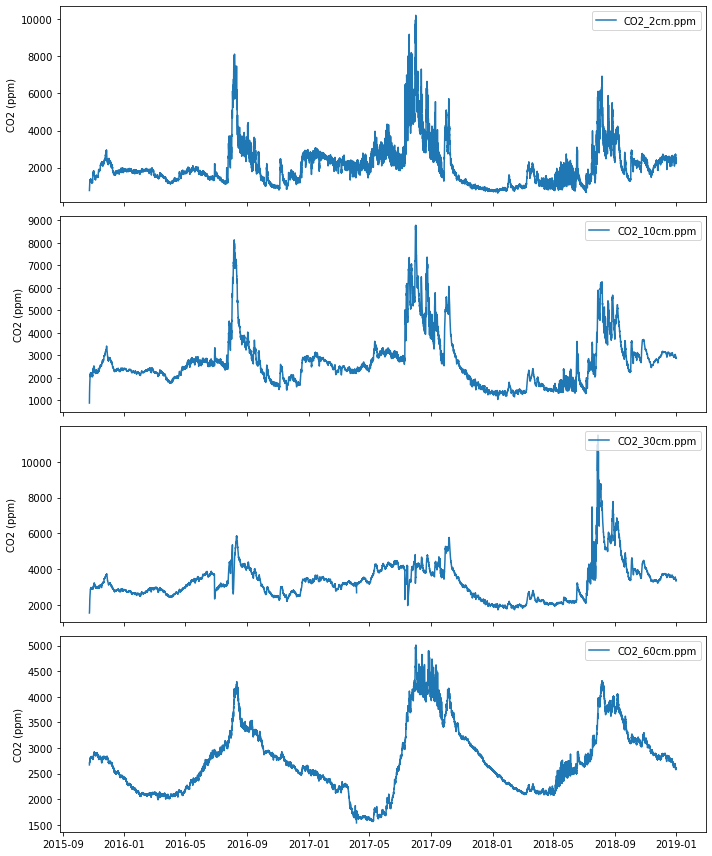

In [6]:
# Plot CO2 data
co2_cols = [col for col in df.columns if 'CO2' in col]
plot_cols(co2_cols, ylabel='CO2 (ppm)');

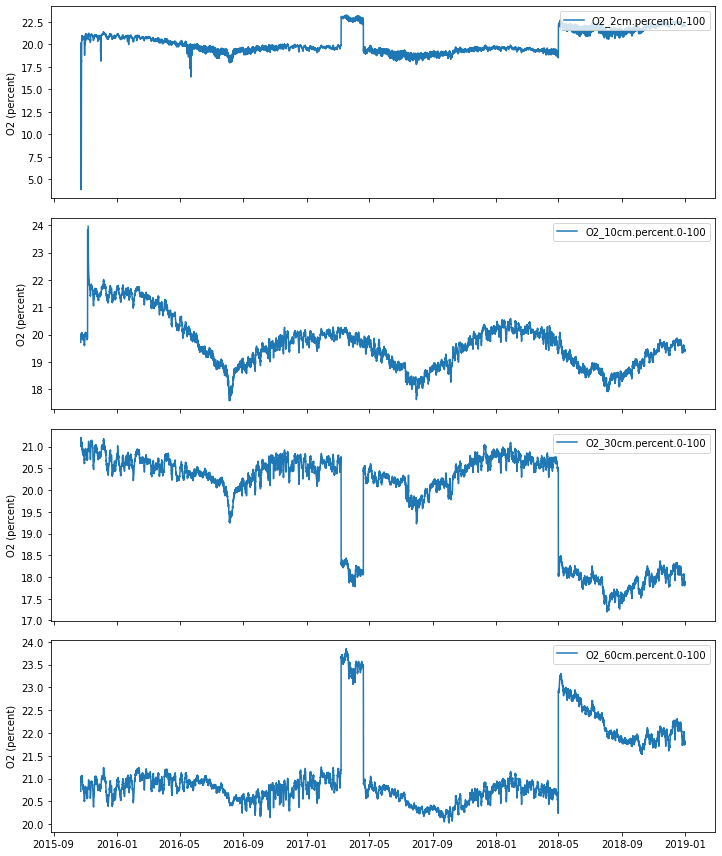

In [7]:
# Plot O2 data
# Weird O2 spikes
df['O2_10cm.percent.0-100'].mask(df['O2_10cm.percent.0-100']>=24, inplace=True)

o2_cols = [col for col in df.columns if col[:2] == 'O2']
plot_cols(o2_cols, ylabel='O2 (percent)');

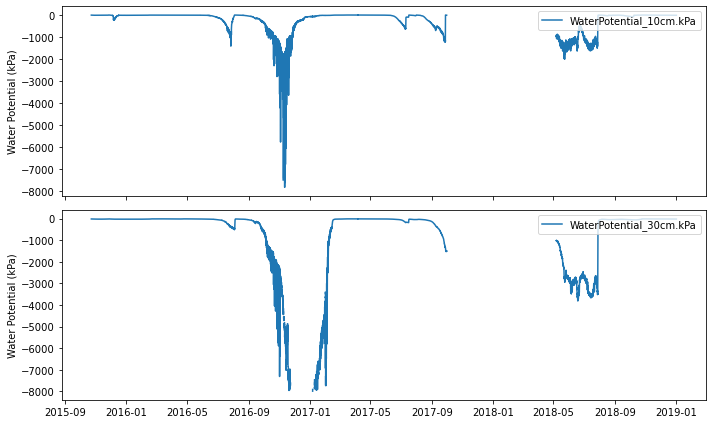

In [8]:
#Plot water potential
water_cols = [col for col in df.columns if 'Water' in col]
plot_cols(water_cols, ylabel='Water Potential (kPa)');

In [9]:
#Merge multiple sensors at same site

SM_10_a=df.loc['2015-01-09':'2017-01-01', 'SoilMoistureA_10cm.m3m3']
SM_10_b=df.loc['2017-02-01':'2019-01-01', 'SoilMoistureB_10cm.m3m3']
df['SoilMoisture_10cm.m3m3']= pd.concat([SM_10_a, SM_10_b])

SM_60_a=df.loc['2015-01-09':'2017-01-01', 'SoilMoistureA_60cm.m3m3']
SM_60_b=df.loc['2017-02-01':'2019-01-01', 'SoilMoistureB_60cm.m3m3']
df['SoilMoisture_60cm.m3m3']= pd.concat([SM_60_a, SM_60_b])

SM_135_a=df.loc['2015-01-09':'2017-01-01', 'SoilMoistureA_135cm.m3m3']
SM_135_b=df.loc['2017-02-01':'2019-01-01', 'SoilMoistureB_135cm.m3m3']
df['SoilMoisture_135cm.m3m3']= pd.concat([SM_135_a, SM_135_b])

EC_10_a=df.loc['2015-01-09':'2017-01-01', 'BulkECA_10cm.dS/m']
EC_10_b=df.loc['2017-02-01':'2019-01-01', 'BulkECB_10cm.dS/m']
df['BulkEC_10cm.dS/m']= pd.concat([EC_10_a, EC_10_b])

EC_60_a=df.loc['2015-01-09':'2017-01-01', 'BulkECA_60cm.dS/m']
EC_60_b=df.loc['2017-02-01':'2019-01-01', 'BulkECB_60cm.dS/m']
df['BulkEC_60cm.dS/m']= pd.concat([EC_60_a, EC_60_b])

EC_135_a=df.loc['2015-01-09':'2017-01-01', 'BulkECA_135cm.dS/m']
EC_135_b=df.loc['2017-02-01':'2019-01-01', 'BulkECB_135cm.dS/m']
df['BulkEC_135cm.dS/m']= pd.concat([EC_135_a, EC_135_b])

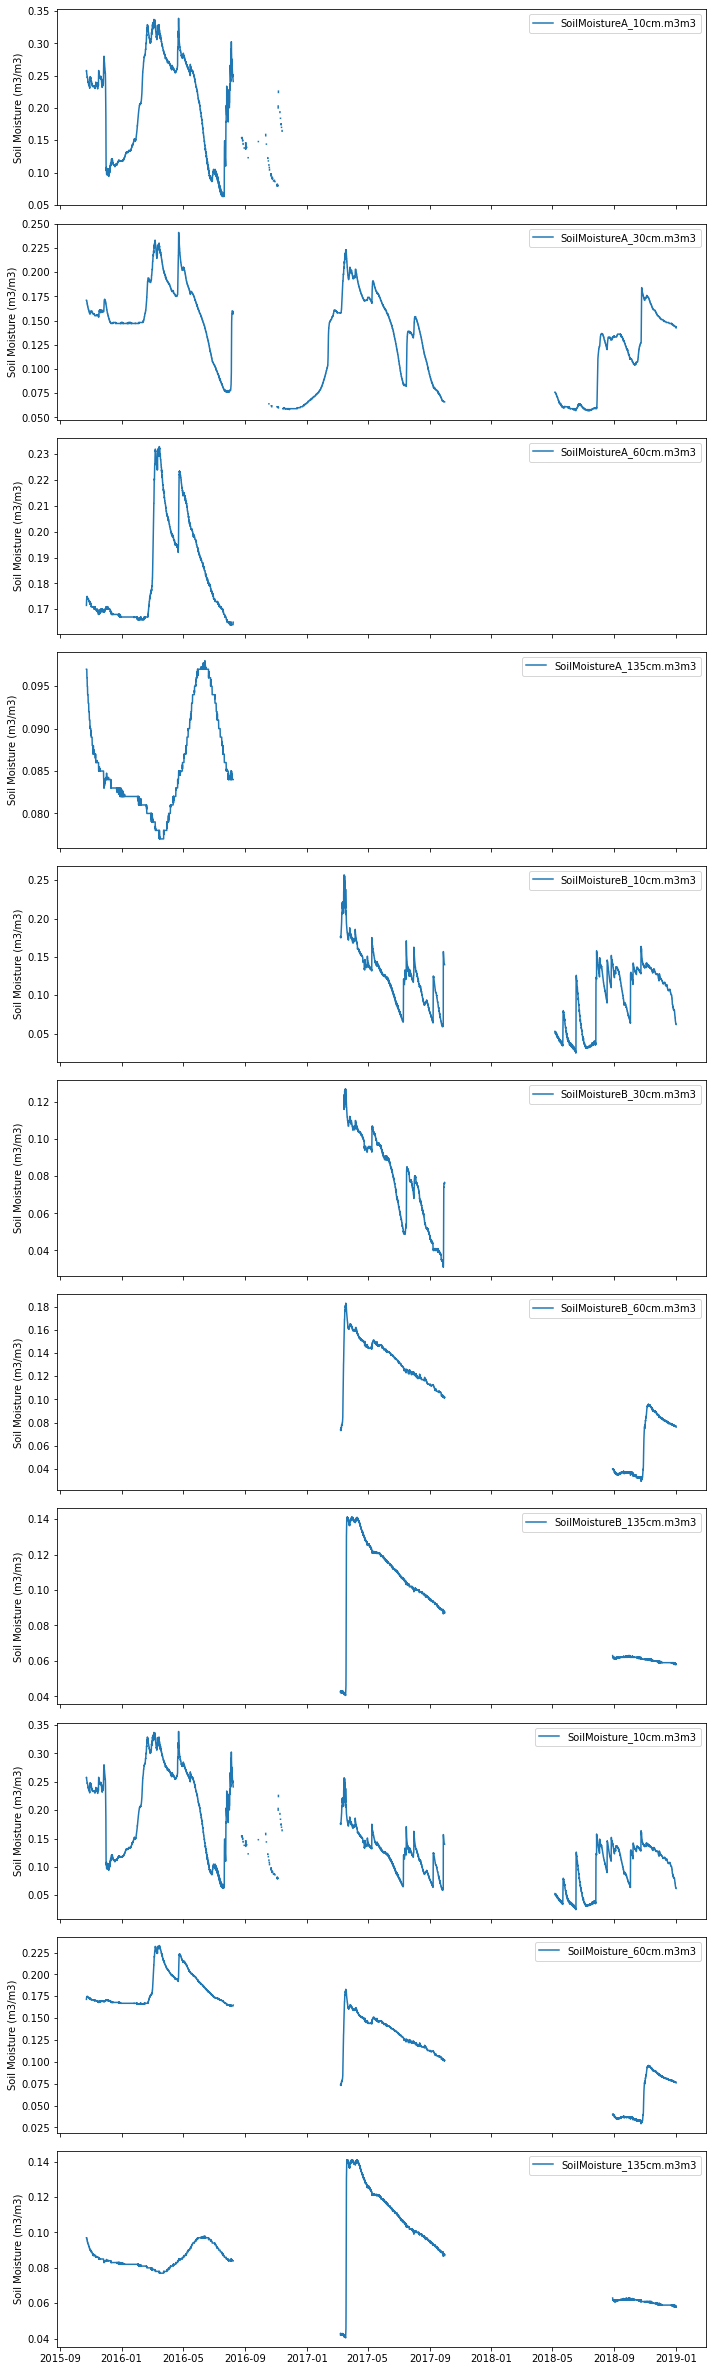

In [10]:
# Plot soil moisture data
sm_cols = [col for col in df.columns if 'SoilMoisture' in col]
plot_cols(sm_cols, ylabel='Soil Moisture (m3/m3)');

In [11]:
df=df.drop(columns='SoilMoistureA_10cm.m3m3')
df=df.drop(columns='SoilMoistureB_10cm.m3m3')
df=df.drop(columns='SoilMoistureA_60cm.m3m3')
df=df.drop(columns='SoilMoistureB_60cm.m3m3')
df=df.drop(columns='SoilMoistureA_135cm.m3m3')
df=df.drop(columns='SoilMoistureB_135cm.m3m3')


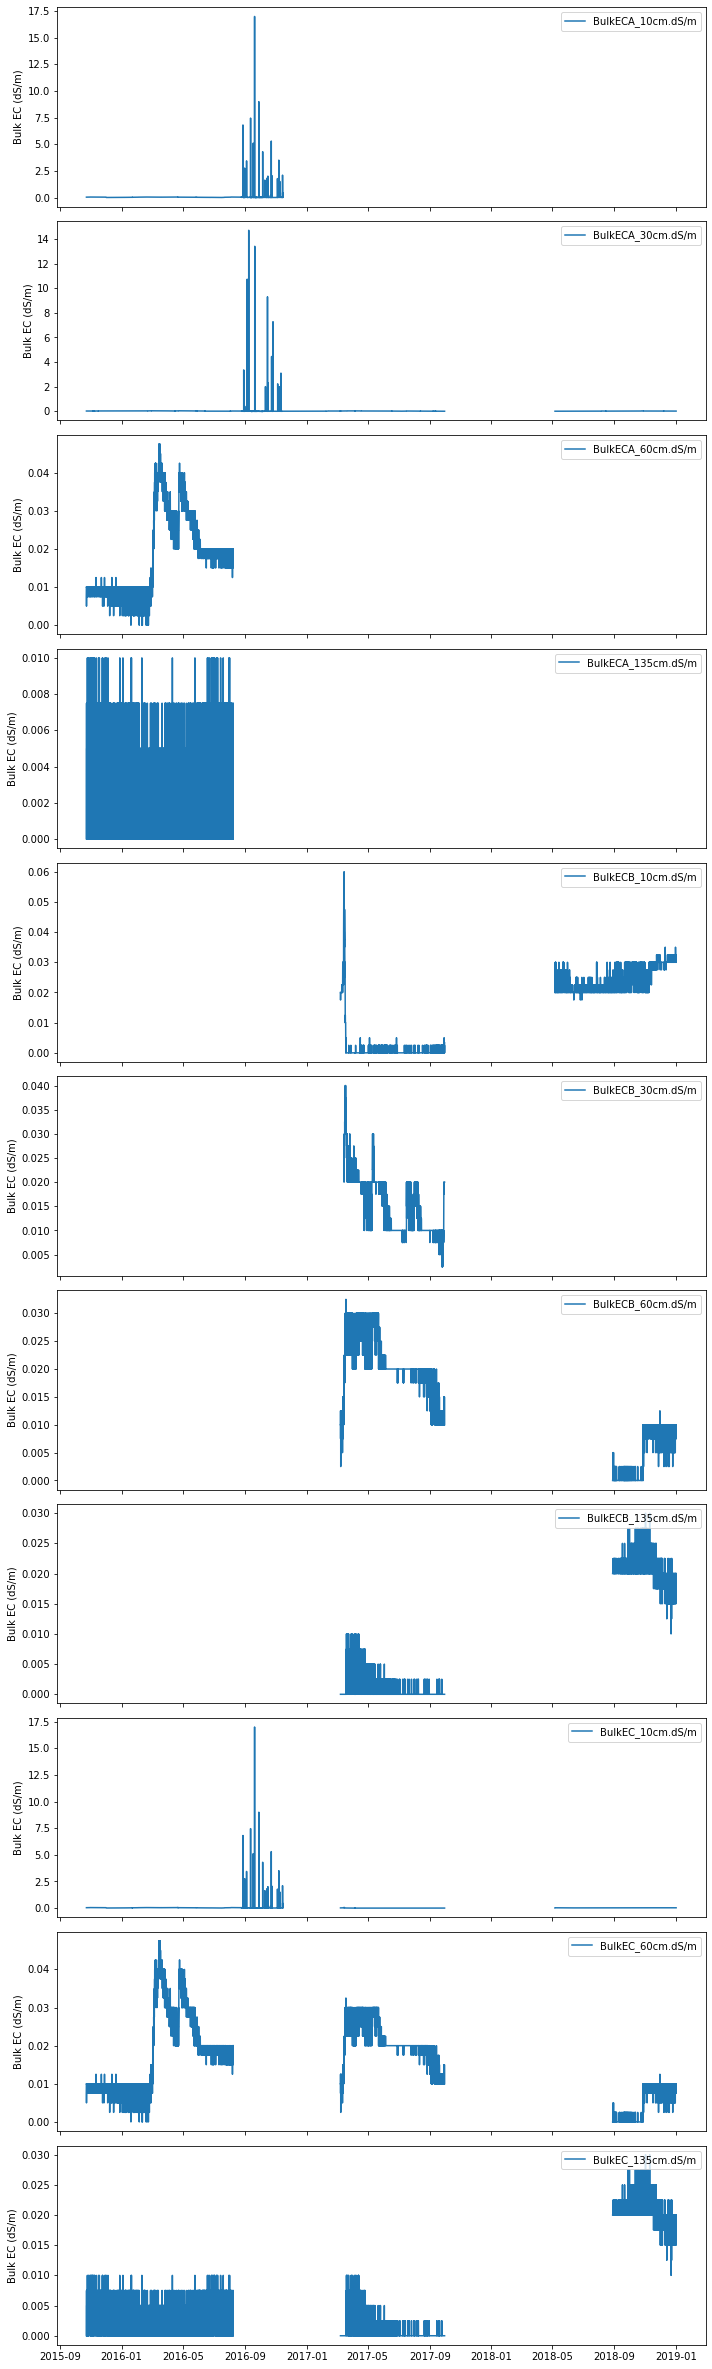

In [12]:
# Plot bulk EC
ec_cols = [col for col in df.columns if 'BulkEC' in col]
plot_cols(ec_cols, ylabel='Bulk EC (dS/m)');

In [13]:
df=df.drop(columns='BulkECA_10cm.dS/m')
df=df.drop(columns='BulkECB_10cm.dS/m')
df=df.drop(columns='BulkECA_60cm.dS/m')
df=df.drop(columns='BulkECB_60cm.dS/m')
df=df.drop(columns='BulkECA_135cm.dS/m')
df=df.drop(columns='BulkECB_135cm.dS/m')



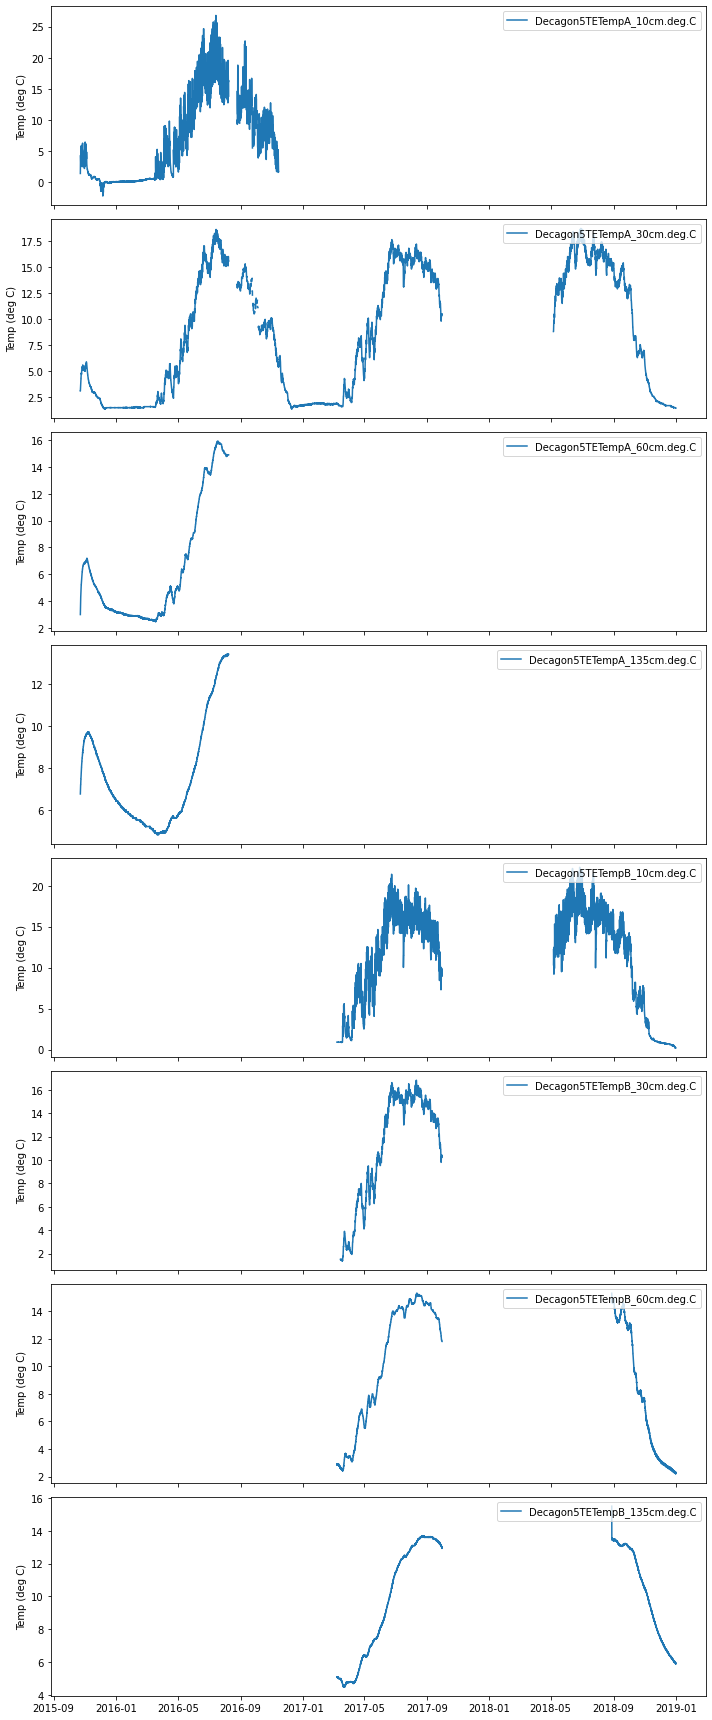

In [14]:
# Plot soil temperature from Decagon 5TE
dec_temp_cols = [col for col in df.columns if 'Decagon5TETemp' in col]

# There are several erroneous values less than -5 deg C
for col in dec_temp_cols:
    df[df[col] < -5] = np.nan
plot_cols(dec_temp_cols, ylabel='Temp (deg C)');

In [15]:
#df=df.drop(columns='Decagon5TETemp_10cm.deg.C')
#df=df.drop(columns='Decagon5TETemp_60cm.deg.C')
#df=df.drop(columns='Decagon5TETemp_135cm.deg.C')
df=df.drop(columns='Decagon5TETempA_10cm.deg.C')
df=df.drop(columns='Decagon5TETempA_30cm.deg.C')
df=df.drop(columns='Decagon5TETempA_60cm.deg.C')
df=df.drop(columns='Decagon5TETempA_135cm.deg.C')
df=df.drop(columns='Decagon5TETempB_10cm.deg.C')
df=df.drop(columns='Decagon5TETempB_30cm.deg.C')
df=df.drop(columns='Decagon5TETempB_60cm.deg.C')
df=df.drop(columns='Decagon5TETempB_135cm.deg.C')
df=df.drop(columns='DecagonMPS6Temp_10cm.deg.C')
df=df.drop(columns='DecagonMPS6Temp_30cm.deg.C')



In [16]:
output=df.copy()
outfile = '../../processed_data/Catalina-Jemez/Green_Pit1_processed.csv'
output.to_csv(outfile, na_rep=-99999, index_label='DateTime.MST')

In [17]:
output

,ApogeeTemp_2cm.deg.C,ApogeeTemp_10cm.deg.C,ApogeeTemp_30cm.deg.C,ApogeeTemp_60cm.deg.C,O2_2cm.percent.0-100,O2_10cm.percent.0-100,O2_30cm.percent.0-100,O2_60cm.percent.0-100,CO2_2cm.ppm,CO2_10cm.ppm,...,BulkECA_30cm.dS/m,SoilMoistureB_30cm.m3m3,BulkECB_30cm.dS/m,PRISM_precip.mm,SoilMoisture_10cm.m3m3,SoilMoisture_60cm.m3m3,SoilMoisture_135cm.m3m3,BulkEC_10cm.dS/m,BulkEC_60cm.dS/m,BulkEC_135cm.dS/m
TIMESTAMP,,,,,,,,,,,,,,,,,,,,,
2015-10-23 09:00:00,3.67200,7.54700,8.78200,11.29550,19.90850,19.71750,21.00600,20.72100,762.66200,884.36700,...,0.0300,NaN,NaN,NaN,0.25750,0.17150,0.09700,0.040,0.0100,0.0000
2015-10-23 10:00:00,4.30800,7.65375,8.90775,11.46575,19.97175,19.94825,21.21225,20.96325,774.03100,927.73575,...,0.0300,NaN,NaN,NaN,0.25775,0.17200,0.09700,0.040,0.0100,0.0050
2015-10-23 11:00:00,5.23175,7.68925,8.93450,11.52150,19.82150,19.94400,21.19225,20.97125,802.02600,997.56500,...,0.0300,NaN,NaN,NaN,0.25800,0.17275,0.09700,0.040,0.0075,0.0000
2015-10-23 12:00:00,6.29575,7.69775,8.93350,11.54875,18.89900,19.93500,21.14725,20.95200,832.92550,1077.96800,...,0.0300,NaN,NaN,NaN,0.25775,0.17300,0.09700,0.040,0.0050,0.0025
2015-10-23 13:00:00,7.02450,7.66775,8.90250,11.54325,18.42100,19.91425,21.10025,20.94325,881.40600,1169.20350,...,0.0300,NaN,NaN,NaN,0.25700,0.17300,0.09700,0.035,0.0075,0.0050
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 19:00:00,-0.06200,0.85100,2.56625,5.91300,22.07675,19.44300,17.89600,21.82625,2366.56575,2894.91175,...,0.0200,NaN,NaN,NaN,0.06200,0.07675,0.05825,0.030,0.0100,0.0200
2018-12-31 20:00:00,-0.04375,0.85100,2.56350,5.91150,22.05375,19.43950,17.87650,21.82275,2421.55525,2898.87900,...,0.0300,NaN,NaN,NaN,0.06200,0.07700,0.05800,0.030,0.0100,0.0200
2018-12-31 21:00:00,-0.02900,0.84900,2.55775,5.90850,22.03225,19.42900,17.87400,21.81900,2456.85900,2904.97900,...,0.0250,NaN,NaN,NaN,0.06200,0.07650,0.05800,0.030,0.0075,0.0175
